In [2]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [48]:
# Load a pre-trained network 
model = models.convnext_tiny(pretrained=True,weight='ConvNeXt_Tiny_Weights')
model.name = "onvnext_tiny"
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [49]:
for param in model.parameters():
    param.requires_grad = False

In [50]:
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 10)  

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [52]:
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [54]:
def validation(model, testloader, criterion,device):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [55]:
def train(model, trainloader, validloader, criterion, optimizer, device, epochs, steps,print_every):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion, device)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model


In [56]:
model = train(model,trainloader, validloader,criterion, optimizer,device, epochs,steps, print_every)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.9959 |  Validation Loss: 1.5898 |  Validation Accuracy: 0.6044
Epoch: 1/5 |  Training Loss: 1.4024 |  Validation Loss: 1.1579 |  Validation Accuracy: 0.7319
Epoch: 1/5 |  Training Loss: 1.0866 |  Validation Loss: 0.9677 |  Validation Accuracy: 0.7730
Epoch: 1/5 |  Training Loss: 0.9674 |  Validation Loss: 0.8453 |  Validation Accuracy: 0.7970
Epoch: 1/5 |  Training Loss: 0.8595 |  Validation Loss: 0.7817 |  Validation Accuracy: 0.8037
Epoch: 1/5 |  Training Loss: 0.7645 |  Validation Loss: 0.7128 |  Validation Accuracy: 0.8230
Epoch: 1/5 |  Training Loss: 0.7176 |  Validation Loss: 0.6710 |  Validation Accuracy: 0.8370
Epoch: 1/5 |  Training Loss: 0.6918 |  Validation Loss: 0.6278 |  Validation Accuracy: 0.8396
Epoch: 1/5 |  Training Loss: 0.6480 |  Validation Loss: 0.6135 |  Validation Accuracy: 0.8367
Epoch: 1/5 |  Training Loss: 0.6191 |  Validation Loss: 0.6020 |  Validation Accuracy: 0.8422
Epoch: 1/5 |  Training 

In [57]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [58]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  37.45922541618347
Accuracy achieved by the network on test images is: 88%


In [59]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


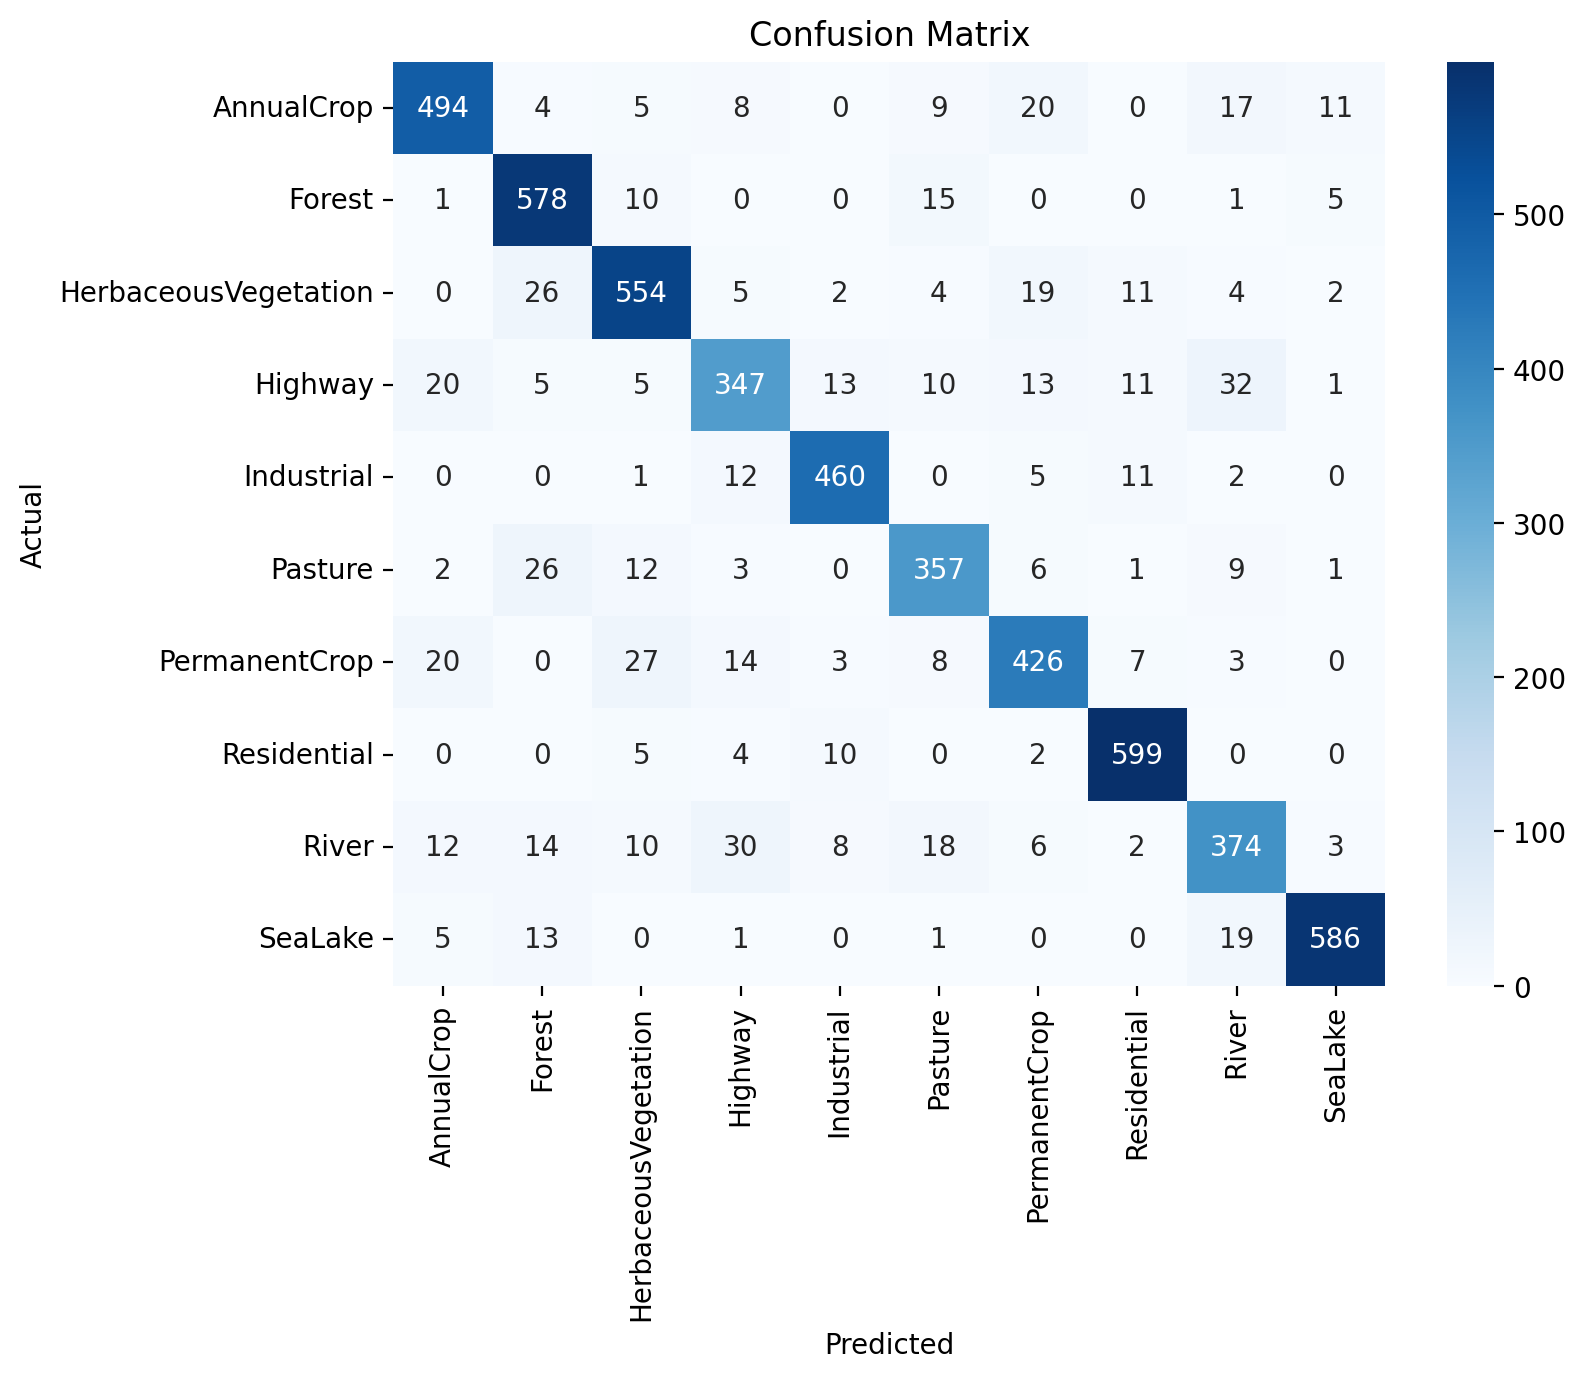

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       568
           1       0.87      0.95      0.91       610
           2       0.88      0.88      0.88       627
           3       0.82      0.76      0.79       457
           4       0.93      0.94      0.93       491
           5       0.85      0.86      0.85       417
           6       0.86      0.84      0.85       508
           7       0.93      0.97      0.95       620
           8       0.81      0.78      0.80       477
           9       0.96      0.94      0.95       625

    accuracy                           0.88      5400
   macro avg       0.88      0.88      0.88      5400
weighted avg       0.88      0.88      0.88      5400



In [60]:
metrics(labels_fp32,predictions_fp32)

In [61]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [62]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:111.37 MB


# Quantization

# FP-16

In [63]:
model_fp16 = copy.deepcopy(model)

In [64]:
model_fp16.half()
model_fp16.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [65]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [66]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  23.115638732910156
Accuracy achieved by the network on test images is: 88%


Confusion Matrix:


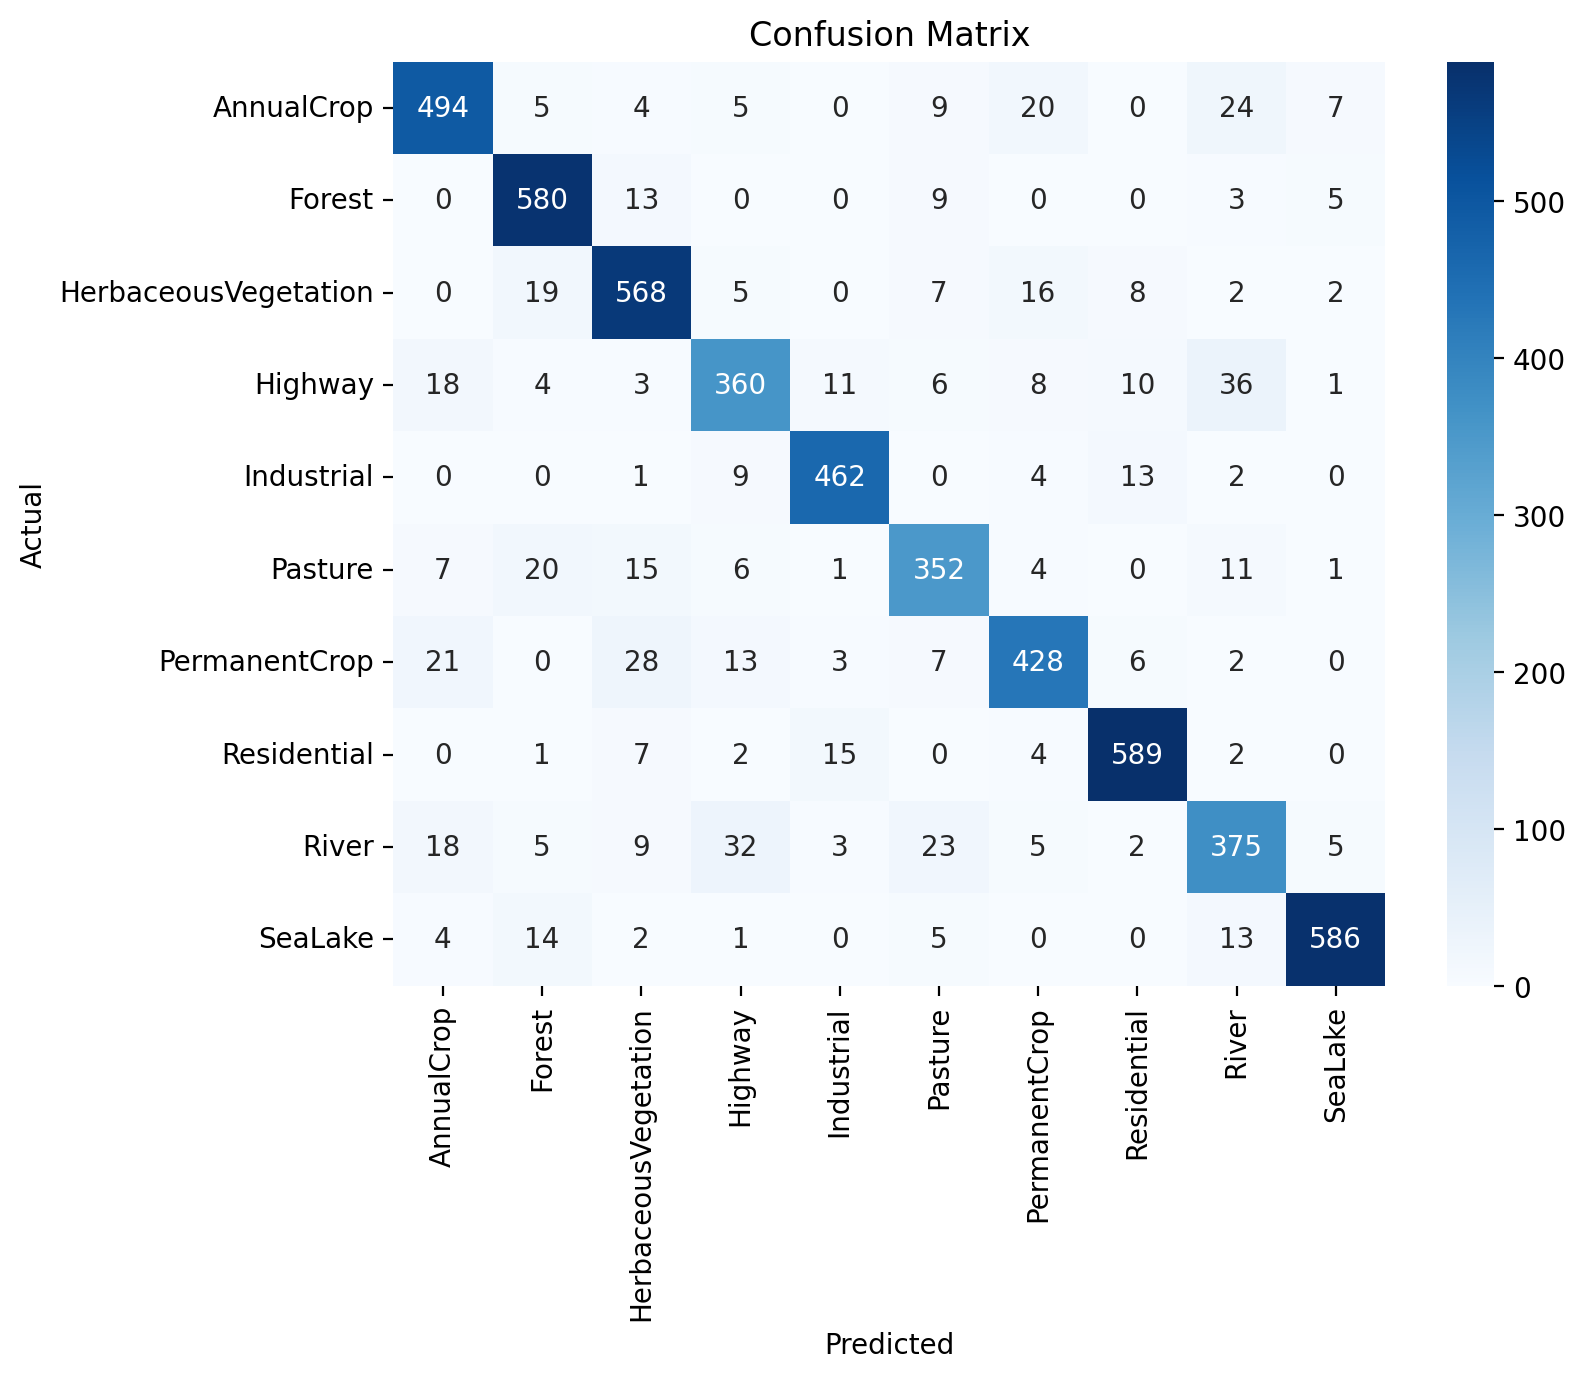

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       568
           1       0.90      0.95      0.92       610
           2       0.87      0.91      0.89       627
           3       0.83      0.79      0.81       457
           4       0.93      0.94      0.94       491
           5       0.84      0.84      0.84       417
           6       0.88      0.84      0.86       508
           7       0.94      0.95      0.94       620
           8       0.80      0.79      0.79       477
           9       0.97      0.94      0.95       625

    accuracy                           0.89      5400
   macro avg       0.88      0.88      0.88      5400
weighted avg       0.89      0.89      0.89      5400



In [67]:
metrics(labels_fp16,predictions_fp16)

# FP-64

In [70]:
model_64 = copy.deepcopy(model)
model_64.double()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [71]:
weights_64 = model_64.state_dict()
for name, param in weights_64.items():
    print(name)

features.0.0.weight
features.0.0.bias
features.0.1.weight
features.0.1.bias
features.1.0.layer_scale
features.1.0.block.0.weight
features.1.0.block.0.bias
features.1.0.block.2.weight
features.1.0.block.2.bias
features.1.0.block.3.weight
features.1.0.block.3.bias
features.1.0.block.5.weight
features.1.0.block.5.bias
features.1.1.layer_scale
features.1.1.block.0.weight
features.1.1.block.0.bias
features.1.1.block.2.weight
features.1.1.block.2.bias
features.1.1.block.3.weight
features.1.1.block.3.bias
features.1.1.block.5.weight
features.1.1.block.5.bias
features.1.2.layer_scale
features.1.2.block.0.weight
features.1.2.block.0.bias
features.1.2.block.2.weight
features.1.2.block.2.bias
features.1.2.block.3.weight
features.1.2.block.3.bias
features.1.2.block.5.weight
features.1.2.block.5.bias
features.2.0.weight
features.2.0.bias
features.2.1.weight
features.2.1.bias
features.3.0.layer_scale
features.3.0.block.0.weight
features.3.0.block.0.bias
features.3.0.block.2.weight
features.3.0.block

In [72]:
weights_64 = model_64.state_dict()
print(weights_64['features.0.0.weight'].dtype)
# print(weights_64['conv1.weight'].dtype)

torch.float64


In [73]:
model_64.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [74]:
def pred_fp64(Model,Testloader): 
    all_labels = [] 
    all_predictions = [] 
    correct = 0 
    total = 0 
    start_time = time() 
    with torch.no_grad(): 
        Model.eval() 
        for images, labels in Testloader: 
            all_labels.extend(labels.numpy()) 
            images, labels = images.to(device), labels.to(device) 
            outputs = Model(images.double())
            _,predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
            predicted_tensor_cpu = predicted.to('cpu') 
            all_predictions.extend(predicted_tensor_cpu.numpy()) 
        end_time = time() 
        print("Time: ",end_time - start_time) 
        print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
        return all_labels,all_predictions

def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [77]:
labels_64,predictions_64 = pred_fp64(model_64,testloader)

Time:  270.2710304260254
Accuracy achieved by the network on test images is: 89%


 labels,predictions = pred_fp64(model_64,testloader)

Confusion Matrix:


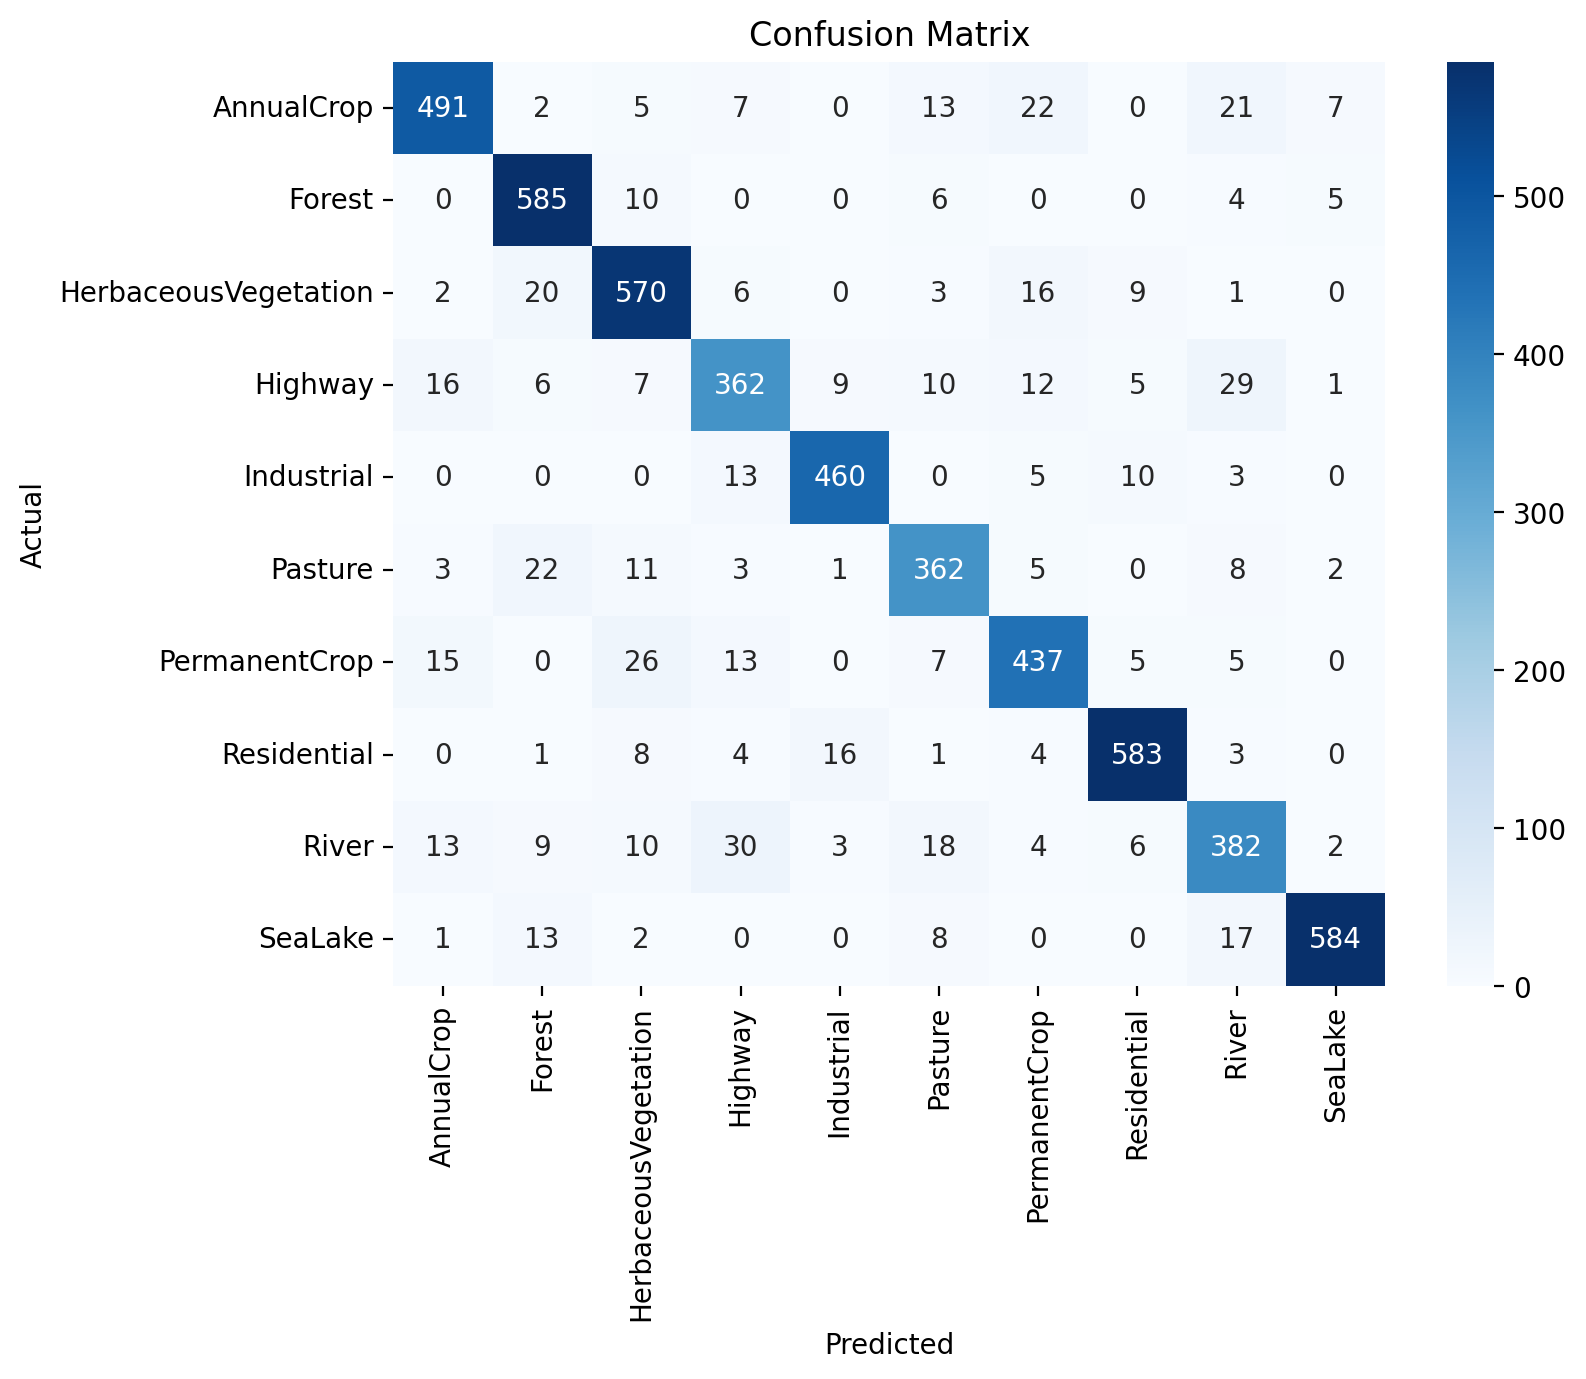

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       568
           1       0.89      0.96      0.92       610
           2       0.88      0.91      0.89       627
           3       0.83      0.79      0.81       457
           4       0.94      0.94      0.94       491
           5       0.85      0.87      0.86       417
           6       0.87      0.86      0.86       508
           7       0.94      0.94      0.94       620
           8       0.81      0.80      0.80       477
           9       0.97      0.93      0.95       625

    accuracy                           0.89      5400
   macro avg       0.89      0.89      0.89      5400
weighted avg       0.89      0.89      0.89      5400



In [78]:
metrics(labels_64,predictions_64)

## INT-8

In [80]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [81]:
model.to('cpu')

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [82]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [83]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [84]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [85]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('features_0_0_input_scale_0', tensor(0.0342)),
             ('features_0_0_input_zero_point_0', tensor(50)),
             ('features_0_1_scale_1', tensor(0.0100)),
             ('features_0_1_zero_point_1', tensor(58)),
             ('features_1_0_scale_0', tensor(0.0034)),
             ('features_1_0_zero_point_0', tensor(67)),
             ('features_1_0_block_1_scale_0', tensor(0.0018)),
             ('features_1_0_block_1_zero_point_0', tensor(66)),
             ('features_1_0_block_4_scale_0', tensor(0.0534)),
             ('features_1_0_block_4_zero_point_0', tensor(3)),
             ('features_1_0_block_6_scale_0', tensor(0.0455)),
             ('features_1_0_block_6_zero_point_0', tensor(64)),
             ('features_1_0_scale_1', tensor(0.0085)),
             ('features_1_0_zero_point_1', tensor(51)),
             ('features_1_0_stochastic_depth_scale_0', tensor(0.0085)),
             ('features_1_0_stochastic_depth_zero_point_0', tensor(51)),
             ('feat

In [86]:
model_quantized_static

GraphModule(
  (features): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 96, kernel_size=(4, 4), stride=(4, 4), scale=0.016453946009278297, zero_point=58)
      (1): Module()
    )
    (1): Module(
      (0): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.0018453479278832674, zero_point=66, padding=(3, 3), groups=96)
          (2): QuantizedLayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): QuantizedLinear(in_features=96, out_features=384, scale=0.11345763504505157, zero_point=67, qscheme=torch.per_channel_affine)
          (4): GELU(approximate='none')
          (5): QuantizedLinear(in_features=384, out_features=96, scale=0.04554577171802521, zero_point=64, qscheme=torch.per_channel_affine)
        )
      )
      (1): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.0043882462196052074, zero_point=70, padding=(3, 3), groups=96

In [87]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 96, kernel_size=(4, 4), stride=(4, 4), scale=0.016453946009278297, zero_point=58)
      (1): Module()
    )
    (1): Module(
      (0): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.0018453479278832674, zero_point=66, padding=(3, 3), groups=96)
          (2): QuantizedLayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): QuantizedLinear(in_features=96, out_features=384, scale=0.11345763504505157, zero_point=67, qscheme=torch.per_channel_affine)
          (4): GELU(approximate='none')
          (5): QuantizedLinear(in_features=384, out_features=96, scale=0.04554577171802521, zero_point=64, qscheme=torch.per_channel_affine)
        )
      )
      (1): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.0043882462196052074, zero_point=70, padding=(3, 3), groups=96

In [88]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  586.3894338607788
Accuracy achieved by the network on test images is: 64%


Confusion Matrix:


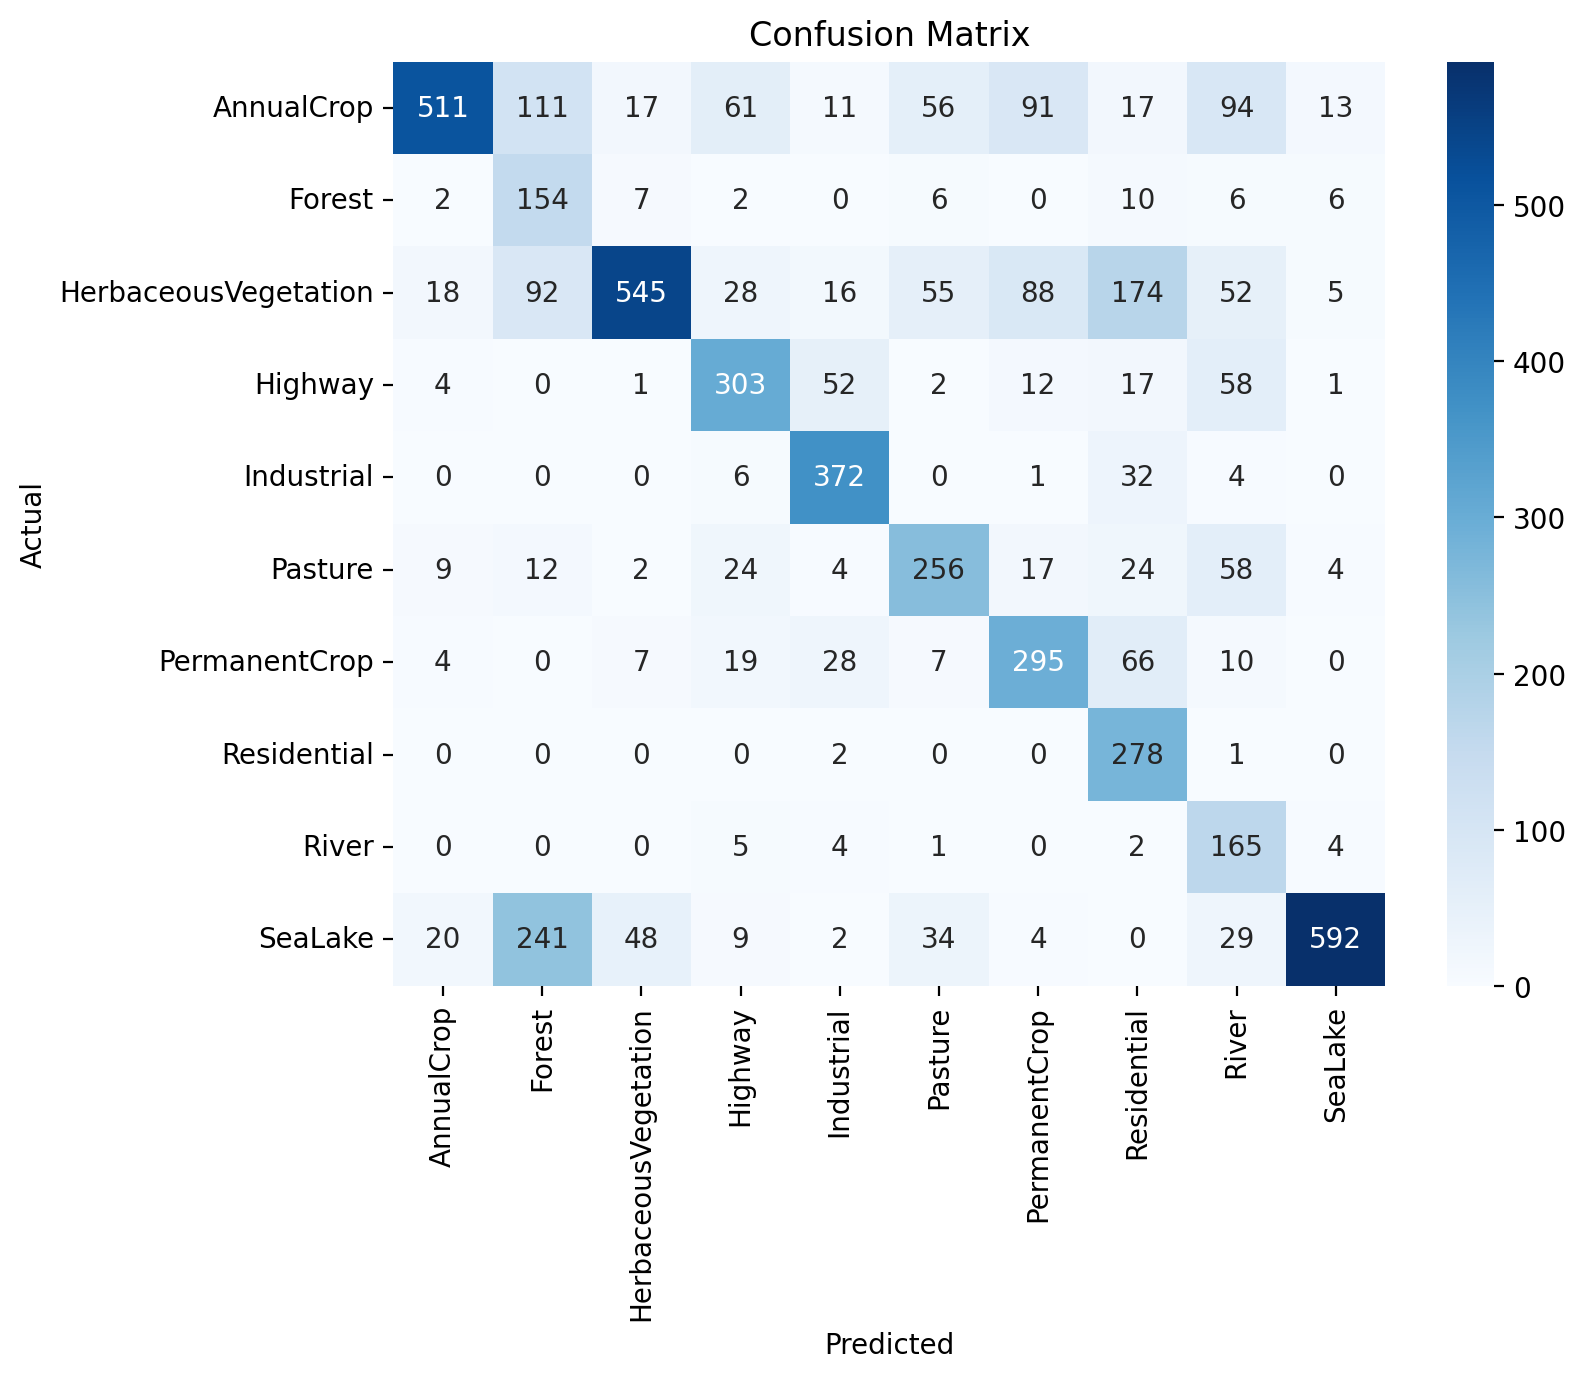

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.52      0.66       982
           1       0.25      0.80      0.38       193
           2       0.87      0.51      0.64      1073
           3       0.66      0.67      0.67       450
           4       0.76      0.90      0.82       415
           5       0.61      0.62      0.62       410
           6       0.58      0.68      0.62       436
           7       0.45      0.99      0.62       281
           8       0.35      0.91      0.50       181
           9       0.95      0.60      0.74       979

    accuracy                           0.64      5400
   macro avg       0.64      0.72      0.63      5400
weighted avg       0.76      0.64      0.66      5400



In [90]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [91]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [92]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [93]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [94]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (features): Module(
    (0): Module(
      (0): Conv2d(
        3, 96, kernel_size=(4, 4), stride=(4, 4)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
          (activation_post_process): MovingAveragePerChannelMin

In [95]:
model = train(model,trainloader, validloader,criterion, optimizer,'cuda', epochs,steps, print_every)

Training process initializing .....



KeyboardInterrupt: 

In [96]:
model_prepared = train(model_prepared,trainloader, validloader,criterion, optimizer,device,epochs,steps,print_every)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 0.6408 |  Validation Loss: 0.6315 |  Validation Accuracy: 0.7904
Epoch: 1/5 |  Training Loss: 0.5452 |  Validation Loss: 0.5218 |  Validation Accuracy: 0.8281
Epoch: 1/5 |  Training Loss: 0.4965 |  Validation Loss: 0.5124 |  Validation Accuracy: 0.8411
Epoch: 1/5 |  Training Loss: 0.5037 |  Validation Loss: 0.5040 |  Validation Accuracy: 0.8433
Epoch: 1/5 |  Training Loss: 0.4824 |  Validation Loss: 0.4948 |  Validation Accuracy: 0.8444
Epoch: 1/5 |  Training Loss: 0.4687 |  Validation Loss: 0.5034 |  Validation Accuracy: 0.8485
Epoch: 1/5 |  Training Loss: 0.6807 |  Validation Loss: 1.4846 |  Validation Accuracy: 0.5500
Epoch: 1/5 |  Training Loss: 1.4092 |  Validation Loss: 1.4152 |  Validation Accuracy: 0.5915
Epoch: 1/5 |  Training Loss: 1.4204 |  Validation Loss: 1.3738 |  Validation Accuracy: 0.6363
Epoch: 1/5 |  Training Loss: 1.3802 |  Validation Loss: 1.3632 |  Validation Accuracy: 0.6574
Epoch: 1/5 |  Training Loss: 1.3781 |  Validation Loss: 1.33

In [97]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0347]), zero_point=tensor([51], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.7678688764572144, max_val=2.6396148204803467)
  )
  (features): Module(
    (0): Module(
      (0): Conv2d(
        3, 96, kernel_size=(4, 4), stride=(4, 4)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.0455e-03, 8.8132e-04, 8.6979e-04, 1.1817e-03, 1.0981e-03, 1.4716e-03,
                  8.0483e-05, 1.7205e-03, 5.9163e-04, 9.9396e-04, 9.2219e-04, 1.3138e-03,
                  1.6544e-03, 8.4335e-04, 7.4061e-04, 1.5462e-03, 6.3502e-04, 5.8783e-04,
                  2.4384e-04, 1.5799e-04, 9.6865e-04, 1.0631e-03, 2

In [98]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [99]:
model_quantized_trained.to('cpu')

GraphModule(
  (features): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 96, kernel_size=(4, 4), stride=(4, 4), scale=0.017624294385313988, zero_point=60)
      (1): Module()
    )
    (1): Module(
      (0): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.003138455795124173, zero_point=62, padding=(3, 3), groups=96)
          (2): QuantizedLayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): QuantizedLinear(in_features=96, out_features=384, scale=0.14400829374790192, zero_point=66, qscheme=torch.per_channel_affine)
          (4): GELU(approximate='none')
          (5): QuantizedLinear(in_features=384, out_features=96, scale=0.06413142383098602, zero_point=65, qscheme=torch.per_channel_affine)
        )
      )
      (1): Module(
        (block): Module(
          (0): QuantizedConv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), scale=0.004700785502791405, zero_point=66, padding=(3, 3), groups=96)


In [100]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  595.0004639625549
Accuracy achieved by the network on test images is: 72%


Confusion Matrix:


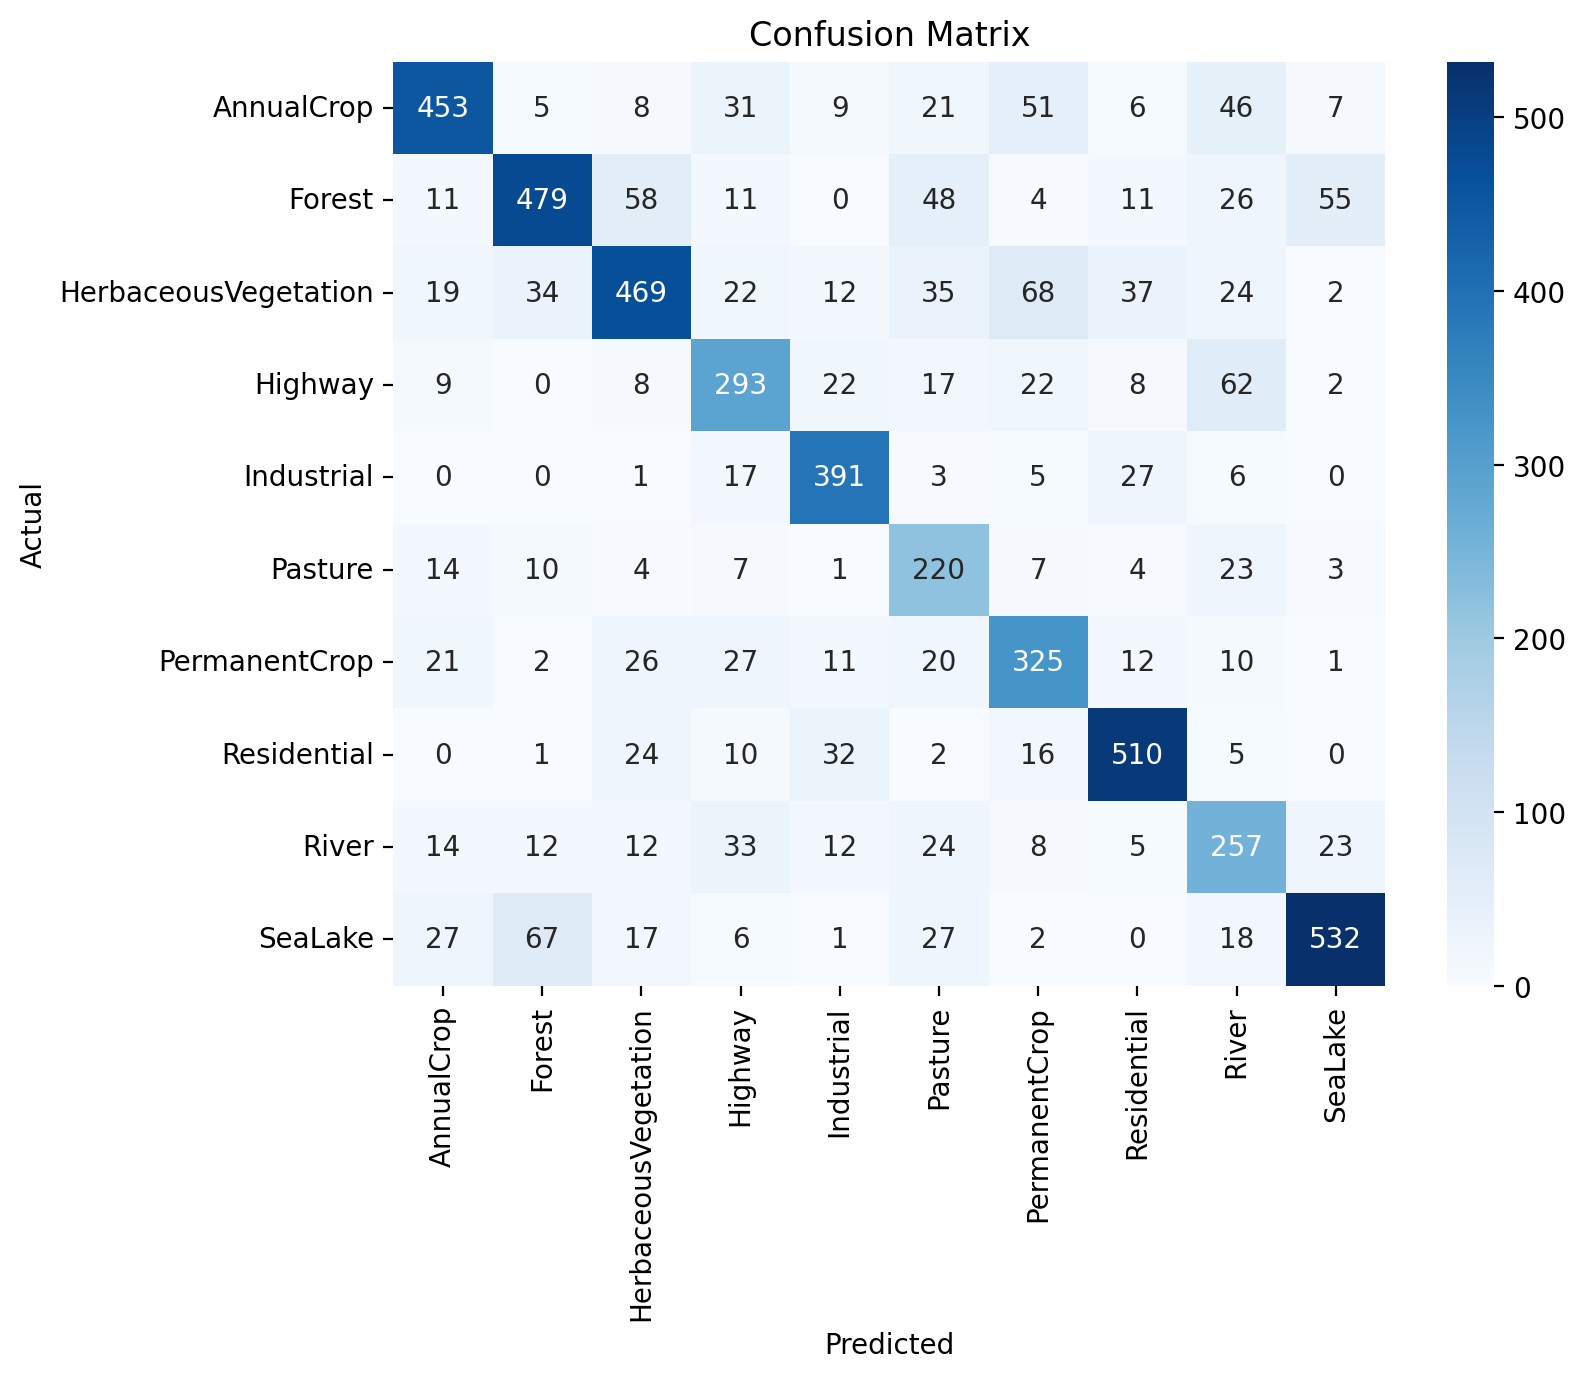

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       637
           1       0.79      0.68      0.73       703
           2       0.75      0.65      0.70       722
           3       0.64      0.66      0.65       443
           4       0.80      0.87      0.83       450
           5       0.53      0.75      0.62       293
           6       0.64      0.71      0.67       455
           7       0.82      0.85      0.84       600
           8       0.54      0.64      0.59       400
           9       0.85      0.76      0.80       697

    accuracy                           0.73      5400
   macro avg       0.71      0.73      0.72      5400
weighted avg       0.74      0.73      0.73      5400



In [104]:
metrics(all_predictions_int8,all_labels_int8)

In [105]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)

Size of fp16 model:55.71 MB
Size of PTQ model:28.88 MB
Size of QAT model:28.88 MB
